# Washington D.C. Bike Sharing Data

# Summary
The goal of this assignment is to Predict the total number of Washington D.C. bicycle users on an hourly basis using a dataset (use attached `hour.csv`, and have a look at `README.txt` for explanations)
 with data from 2011 and 2012. The notebook shold be divided in the following sections:

### Part 1: Exploratory Data Analysis
1. Ensuring data quality
2. Plotting clear and meaningful figures
3. Checking possibly redundant variables via correlations
4. Giving insights on what seems relevant for prediction and what does not

### Part 2: Data Engineering
1. Discussion on missing values and outliers
2. Treatment of text and date features
3. Generation of extra features and studying the influence of combinations of features
4. Giving new insights on what seems relevant for prediction and what does not
5. Use of scikit-learn pipelines to perform transformations

### Part 3: Machine Learning
1. Choosing sensible models (linear and non-linear)
    * Baseline Linear Regression with Initial Variables
    * Linear Regression with New Variables
    * Baseline Random Forest
2. Tuning model parameters with validation
3. Obtaining accurate predictions in test
4. Plotting predictions vs reality for additional insights

### Importing the necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import calendar 
from datetime import datetime
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import validation_curve
import missingno as msno
import warnings
warnings.simplefilter("ignore")

### Importing the dataset

In [2]:
df = pd.read_csv("hour.csv")
df.head()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


### Creating the Baseline Model

In [3]:
x = df.drop(columns={'casual','registered','instant','cnt','dteday'}, axis=1)
y = df['cnt']

In [4]:
categorical_features = list(x.select_dtypes(include=["object", "category"]).columns)
numerical_features = list(x.select_dtypes(include=["float64", "int64"]).columns)

In [5]:
# Define categorical pipeline
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])


# Fit column transformer to training data
preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("num", num_pipe, numerical_features)
])

preprocessor.fit(x)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['weathersit']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['hr', 'temp', 'atemp', 'hum', 'windspeed'])])

In [6]:
# transformed dataframe
x_preprocessed = pd.DataFrame(preprocessor.transform(x))

In [7]:
# reg = linear_model.LinearRegression()

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .125, random_state= 42, shuffle=False)

In [9]:
linear_regression = Pipeline([
    ("preprocessor", preprocessor),
    ("LinearRegression", LinearRegression())    
])

In [10]:
linear_regression.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['weathersit']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['hr', 'temp', 'atemp', 'hum',
                                                   'w

In [11]:
pred = linear_regression.predict(x_test)

In [12]:
print(f" The Baseline Model score is: {r2_score(y_test, pred)}")

 The Baseline Model score is: 0.14260249043893936


##### Now that we have our Baseline Model we are going to work on understanding the datasets and finding new insights to develop our model further.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   hr          17379 non-null  int64  
 3   weathersit  17279 non-null  object 
 4   temp        17280 non-null  float64
 5   atemp       17279 non-null  float64
 6   hum         17279 non-null  float64
 7   windspeed   17279 non-null  float64
 8   casual      17379 non-null  int64  
 9   registered  17379 non-null  int64  
 10  cnt         17379 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 1.5+ MB


### Renaming Features

In [14]:
df = df.rename(columns={'instant':'index','hr':"hour","dteday":"date",'weathersit':'weather_cond','temp':'temperature',
                'hum':"humidity","cnt":"count"})

### Checking unique values

In [15]:
df.apply(lambda x: len(x.unique()))

index           17379
date              731
hour               24
weather_cond        5
temperature        51
atemp              66
humidity           90
windspeed          31
casual            322
registered        776
count             869
dtype: int64

### Binning the Hour column 

In [16]:
labels = ["{0} - {1}".format(i,i + 4) for i in range(0,24,5)]
df['hour_group'] = pd.cut(df['hour'], range(0,25,4), right =False)
df['hour_group'].value_counts()

[16, 20)    2916
[12, 16)    2915
[20, 24)    2912
[8, 12)     2908
[4, 8)      2866
[0, 4)      2862
Name: hour_group, dtype: int64

### Merging hour and date together

In [17]:
df['date'] = pd.to_datetime(df['date'] + df['hour'].astype('str'), format='%Y-%m-%d%H')

In [18]:
df.drop(columns={"index","hour"}, axis=1, inplace=True)

### Creating date features

In [19]:
df['year'] = df.date.apply(lambda x: x.year)
df['month'] = df.date.apply(lambda x: x.month)
df['day'] = df.date.apply(lambda x: x.day)
df['hour'] = df.date.apply(lambda x: x.hour)

### Checking for Missing Values

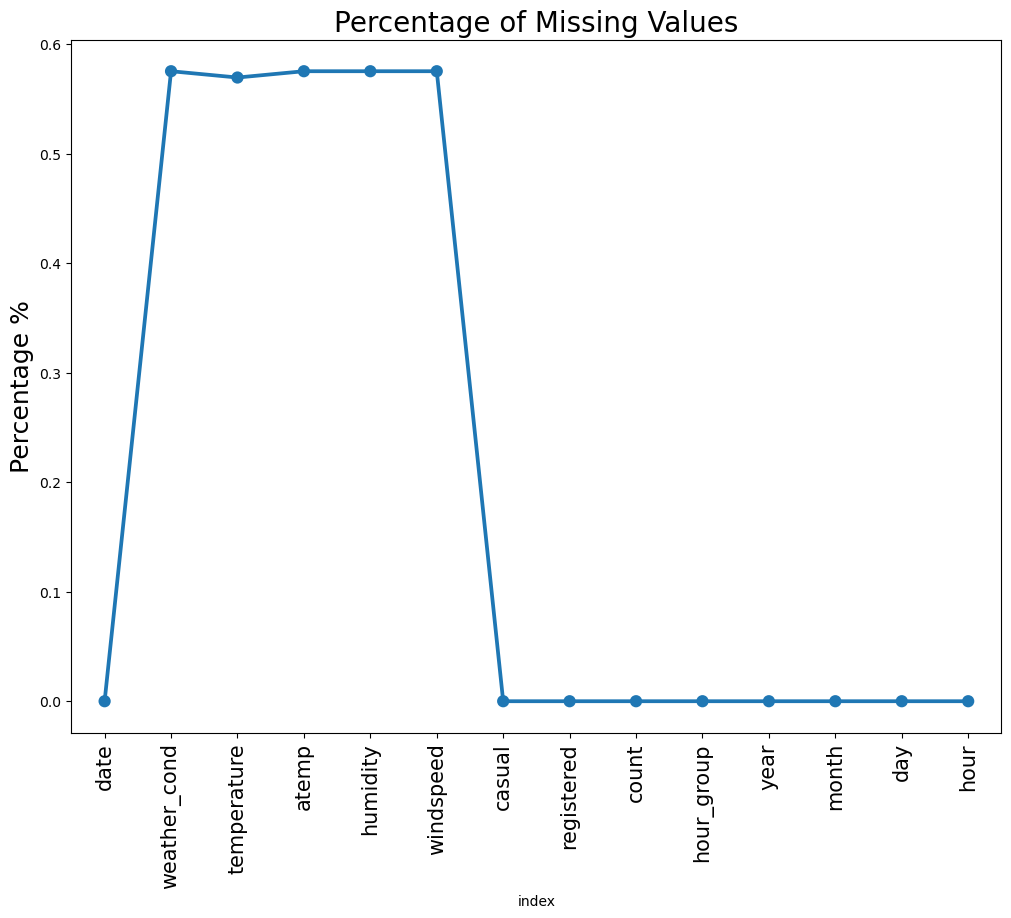

In [20]:
missing_values = pd.DataFrame((df.isnull().sum())*100/df.shape[0]).reset_index()
plt.figure(figsize=(12,9))
ax =sns.pointplot('index',0,data=missing_values)
plt.xticks(rotation=90, fontsize=15)
plt.title("Percentage of Missing Values", fontsize =20)
plt.ylabel("Percentage %",fontsize =18)
plt.show()

<AxesSubplot:>

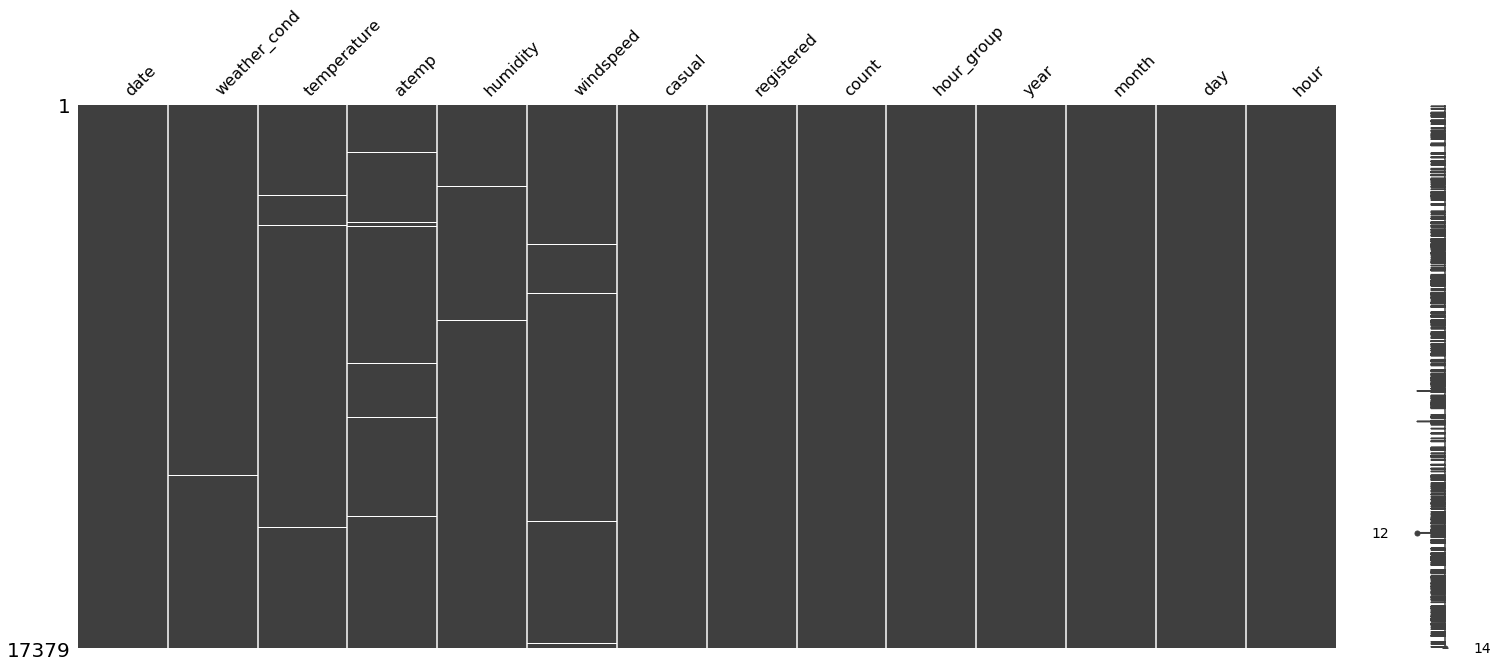

In [23]:
msno.matrix(df)

<AxesSubplot:>

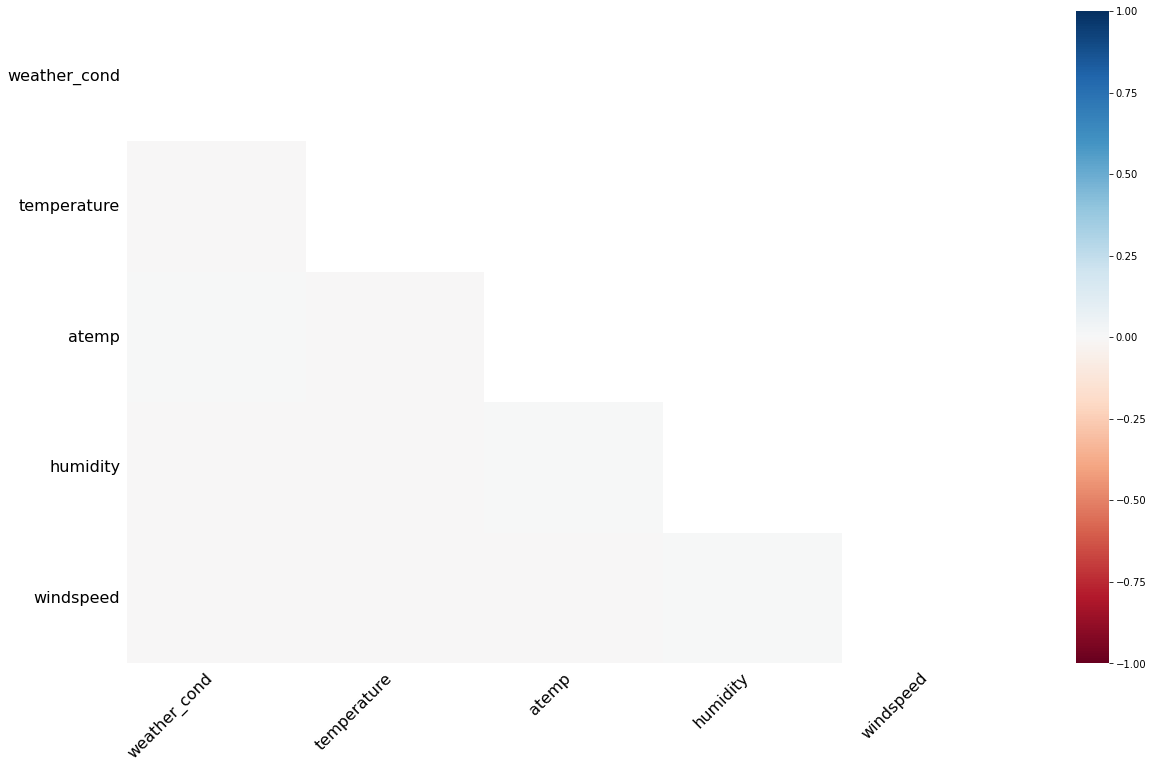

In [25]:
msno.heatmap(df)

### Checking correlation amongst features.

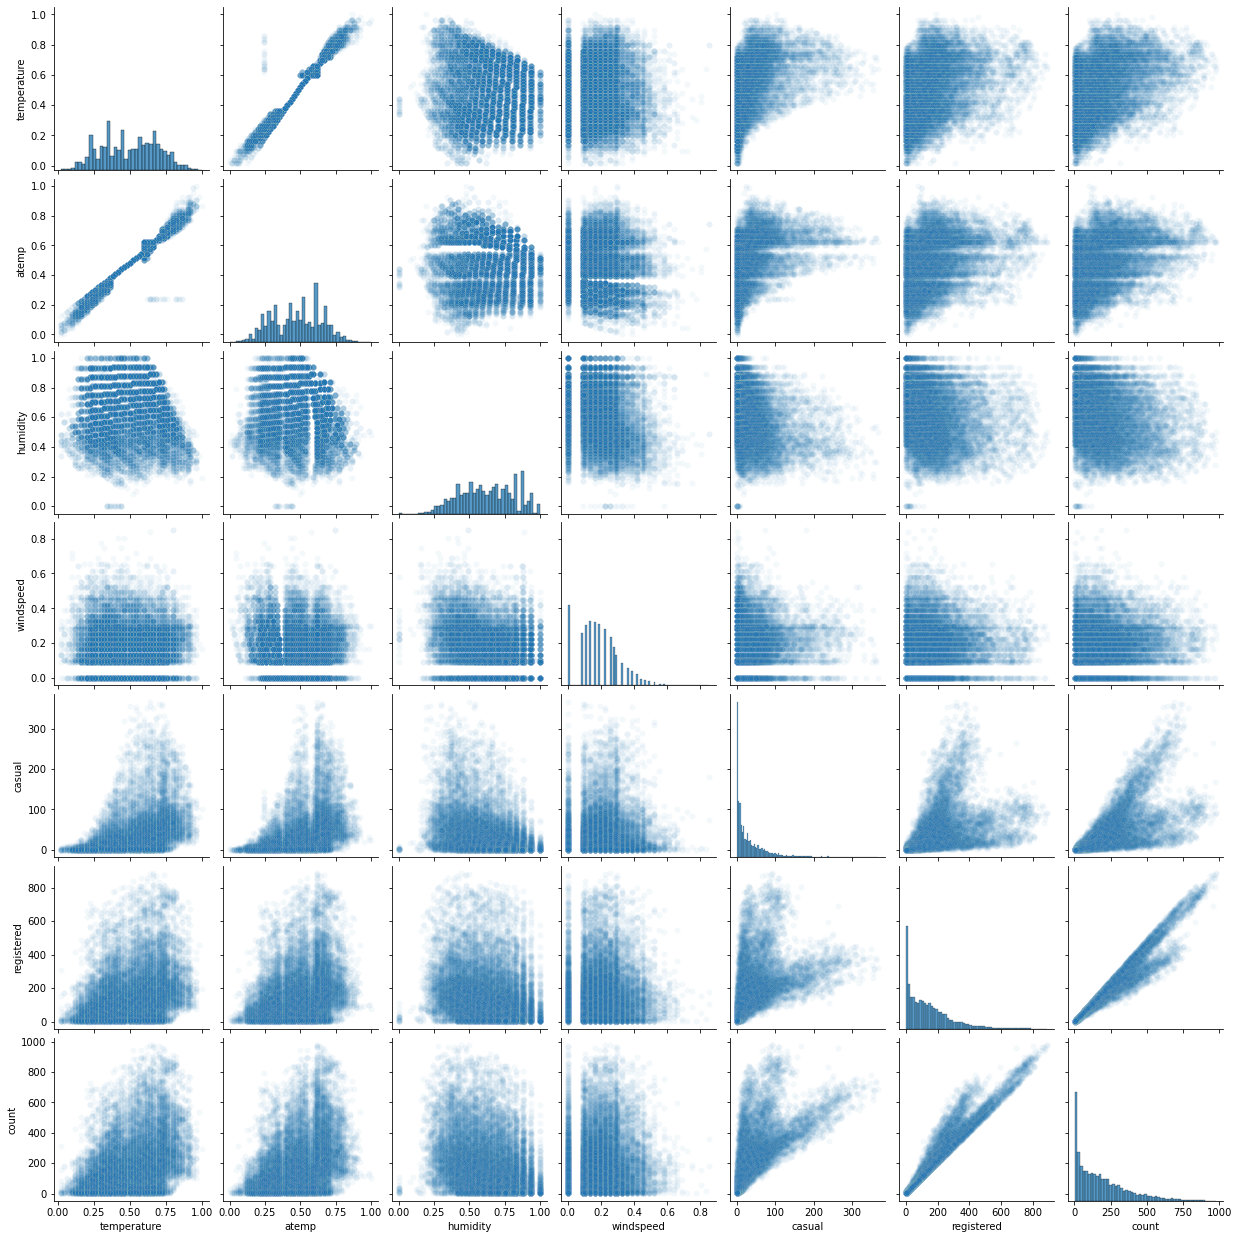

In [28]:
cols = ['temperature','atemp','humidity','windspeed','casual','registered','count']
sns.pairplot(df[cols],plot_kws={'alpha':0.05})

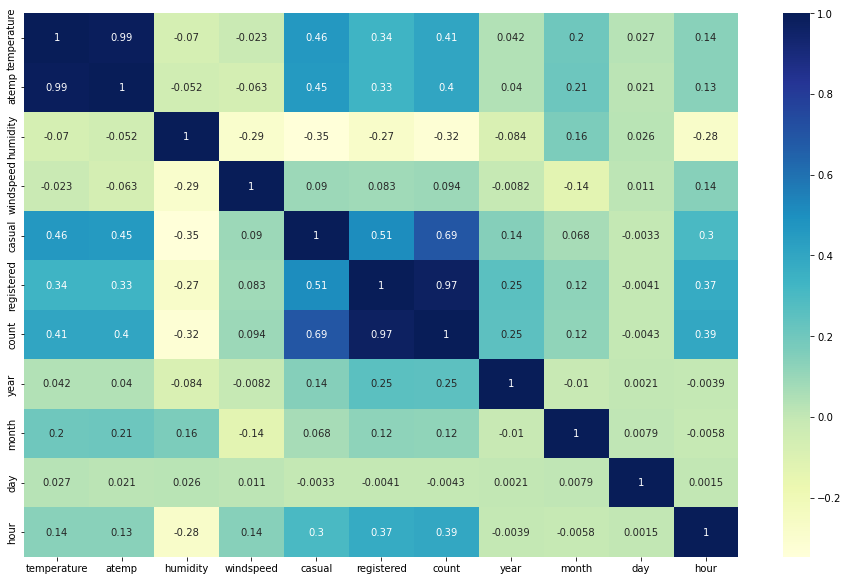

In [27]:
plt.figure(figsize = (16, 10))
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")
plt.show()

### Insights from the above plots

#### - There are no categorical Features that are present in the dataset that we have considered.
#### - The features are normally distributed and count has an expected heavy tailed distribution

### Getting rid of redundant features 
#### - Based on the correlation matrix

In [29]:
df.drop(['atemp','registered','casual'], axis=1, inplace=True)
df.head()

,date,weather_cond,temperature,humidity,windspeed,count,hour_group,year,month,day,hour
0,2011-01-01 00:00:00,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.81,0.0,16,"[0, 4)",2011,1,1,0
1,2011-01-01 01:00:00,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.80,0.0,40,"[0, 4)",2011,1,1,1
2,2011-01-01 02:00:00,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.80,0.0,32,"[0, 4)",2011,1,1,2
3,2011-01-01 03:00:00,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.75,0.0,13,"[0, 4)",2011,1,1,3
4,2011-01-01 04:00:00,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.75,0.0,1,"[4, 8)",2011,1,1,4


## Handling Outliers

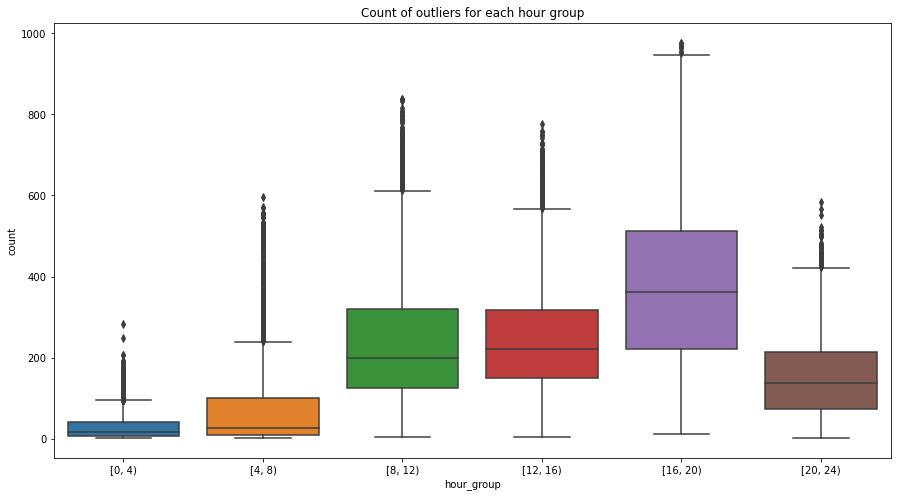

In [30]:
fig,ax=plt.subplots(figsize=(15,8))
sns.boxplot(x="hour_group", y= "count", data=df)
ax.set_title('Count of outliers for each hour group')
plt.show()

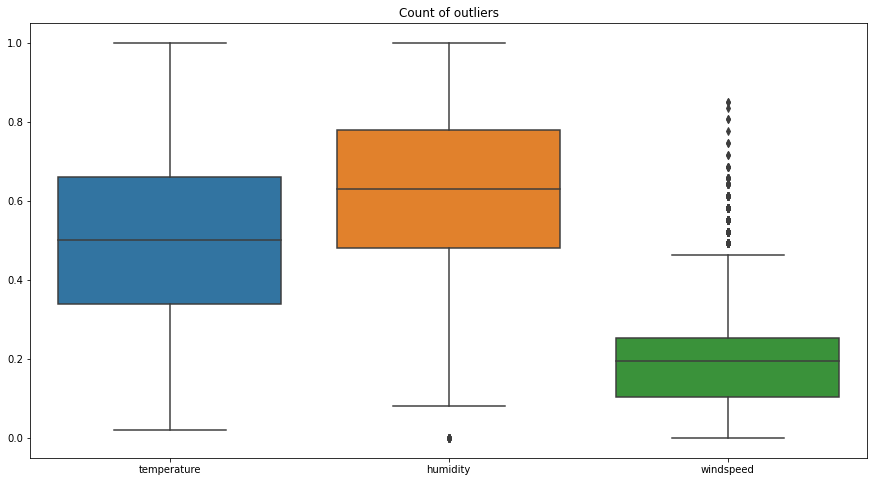

In [31]:
fig,ax=plt.subplots(figsize=(15,8))
sns.boxplot(data=df[['temperature', 'humidity', 'windspeed']])
ax.set_title('Count of outliers')
plt.show()

### Meaningful visualizations from our modified dataset

<Figure size 864x576 with 0 Axes>

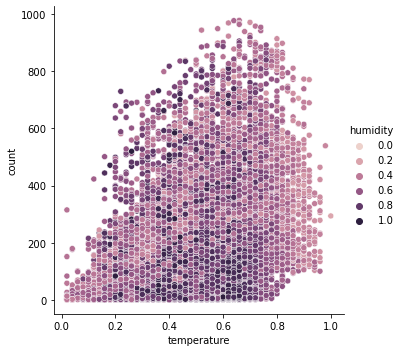

In [32]:
plt.figure(figsize=(12,8))
sns.relplot(data=df, x="temperature",y="count", hue="humidity")
plt.show()

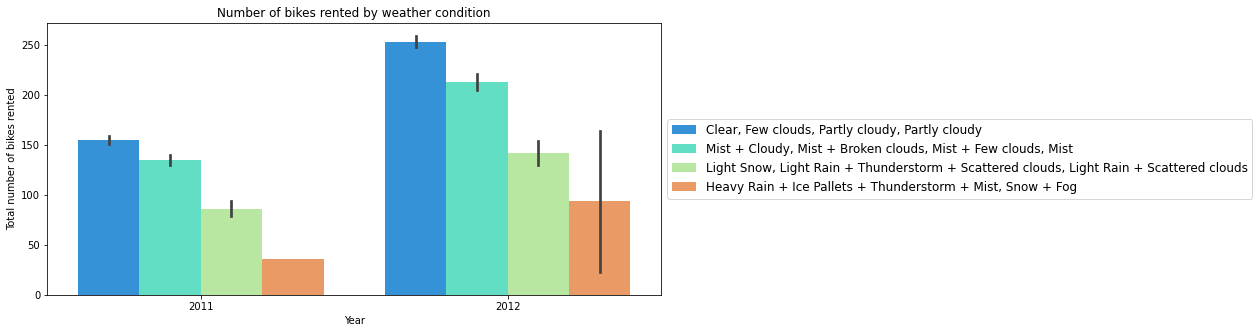

In [33]:
plt.figure(figsize=(11,5))
sns.barplot(df['date'].dt.year,'count',hue=df['weather_cond'], data=df, palette='rainbow')
plt.xlabel('Year')
plt.ylabel('Total number of bikes rented')
plt.title('Number of bikes rented by weather condition')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 12)
plt.show()

Text(0.5, 1.0, 'Demand at Different Hours across Years')

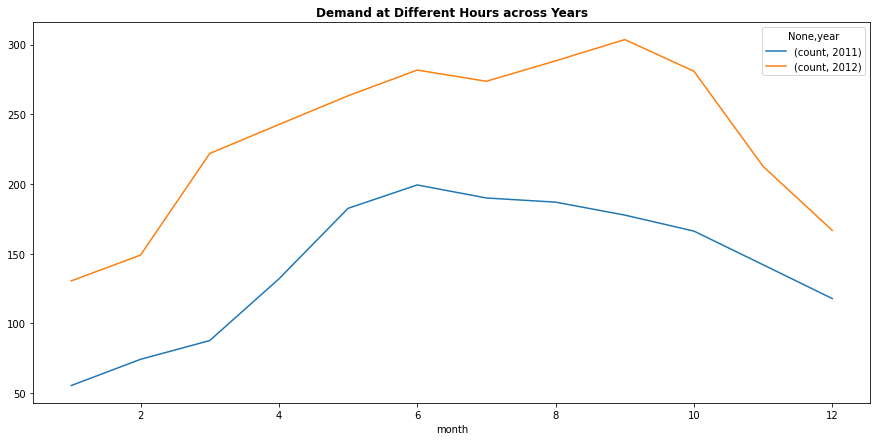

In [34]:
df['hour'] = df['date'].dt.hour
df['year'] = df.date.dt.year

piv = pd.pivot_table(df, index=['month'],columns=['year'], values=['count'])

piv.plot(figsize=(15, 7)).set_title('Demand at Different Hours across Years', fontweight="bold")

### Part 2: Data Engineering
1. Discussion on missing values and outliers
2. Treatment of text and date features
3. Generation of extra features and studying the influence of combinations of features
4. Giving new insights on what seems relevant for prediction and what does not
5. Use of scikit-learn pipelines to perform transformations

### Do we have Nulls?

In [31]:
df.isnull().sum()

date              0
weather_cond    100
temperature      99
humidity        100
windspeed       100
count             0
hour_group        0
year              0
month             0
day               0
hour              0
dtype: int64

### Imputing null values

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

missing_data_transformer = ColumnTransformer(
    [
        (
            "fill_missing_values_with_mode", 
            SimpleImputer(strategy="most_frequent", fill_value=df['weather_cond'].mode()), 
            ['weather_cond']
        ),
        (
            "fill_missing_values_with_mean", 
            SimpleImputer(strategy="mean"), 
            ['temperature', 'humidity', 'windspeed']
        )
    ],
    remainder="drop" 

)
missing_data_transformed = pd.DataFrame(
    missing_data_transformer.fit_transform(df),
    columns=["weather_cond", "temperature", "humidity", "windspeed"]
)

missing_data_transformed.isna().mean()
df.loc[:, ["weather_cond", "temperature", "humidity", "windspeed"]] = missing_data_transformed
df.head()

df["temperature"] = df['temperature'].astype(float)
df["humidity"] = df['humidity'].astype(float)
df["windspeed"] = df['windspeed'].astype(float)

### Creating new relevant features

In [33]:
df['daytime'] = df.hour.apply(lambda x: 1 if x in range(6,19) else 0)
df['weekday'] = df.date.apply(lambda date : calendar.day_name[date.weekday()])
df['weekend'] = df.weekday.apply(lambda x: 1 if x == 'Saturday' or x == 'Sunday' else 0)

###### 1. Weather Conditions

In [34]:
def weather(item):
    if item == 'Clear, Few clouds, Partly cloudy, Partly cloudy':
        return 0
    elif item == 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist':
        return 1
    elif item == 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds':
        return 2
    else: 
        return 3

In [35]:
df['weather_conditions'] = df['weather_cond'].apply(weather)

In [36]:
df['weather_conditions'] = df.weather_conditions.astype("category")

In [37]:
df.drop('weather_cond',axis=1, inplace=True)

###### 2. Season

In [38]:
def get_season(y):
    if (y < 3) or (y == 12):
        return 'Winter' 
    elif (y >= 3) and (y <= 5):
        return 'Spring'
    elif (y >= 6) and (y <= 8):
        return 'Summer'
    elif (y >= 9) and (y <= 11) :
        return 'Fall'

In [39]:
df['season'] = df['month'].apply(get_season)

In [40]:
df['season'] = df.season.astype("category")

###### 3. Holiday

In [41]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=df['date'].min(), end=df['date'].max())

df['is_holiday'] = df['date'].isin(holidays)
df['is_holiday'] = df["is_holiday"].astype('bool').astype(int)

###### 4. Period of the day

In [42]:
def get_period(x):
    if (x >= 5) and (x < 12):
        return 'Morning'
    elif (x >= 12) and (x <= 16):
        return 'Afternoon'
    elif (x > 16) and (x <= 19) :
        return 'Evening'
    elif (x > 19) and (x <= 24):
        return 'Night'
    elif (x <= 4):
        return 'Late Night'

In [43]:
df['period_of_day'] = df['hour'].apply(get_period)

In [44]:
df['period_of_day'] = df.period_of_day.astype("category")
df['is_holiday'] = df.is_holiday.astype("category")

In [45]:
fig,ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=df, x='hour',y='count',hue='weekday',ax=ax)
ax.set_title('Count bikes during weekdays', fontsize = 20)

Text(0.5, 1.0, 'Count bikes during weekdays')

In [46]:
fig,ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=df, x='hour',y='count',hue='weekend',ax=ax)
ax.set_title('Count bikes weekdays vs weekends', fontsize=20)

Text(0.5, 1.0, 'Count bikes weekdays vs weekends')

In [47]:
fig,ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=df, x='hour',y='count',hue='daytime',ax=ax)
ax.set_title('Count of bikes day vs night', fontsize=20)

Text(0.5, 1.0, 'Count of bikes day vs night')

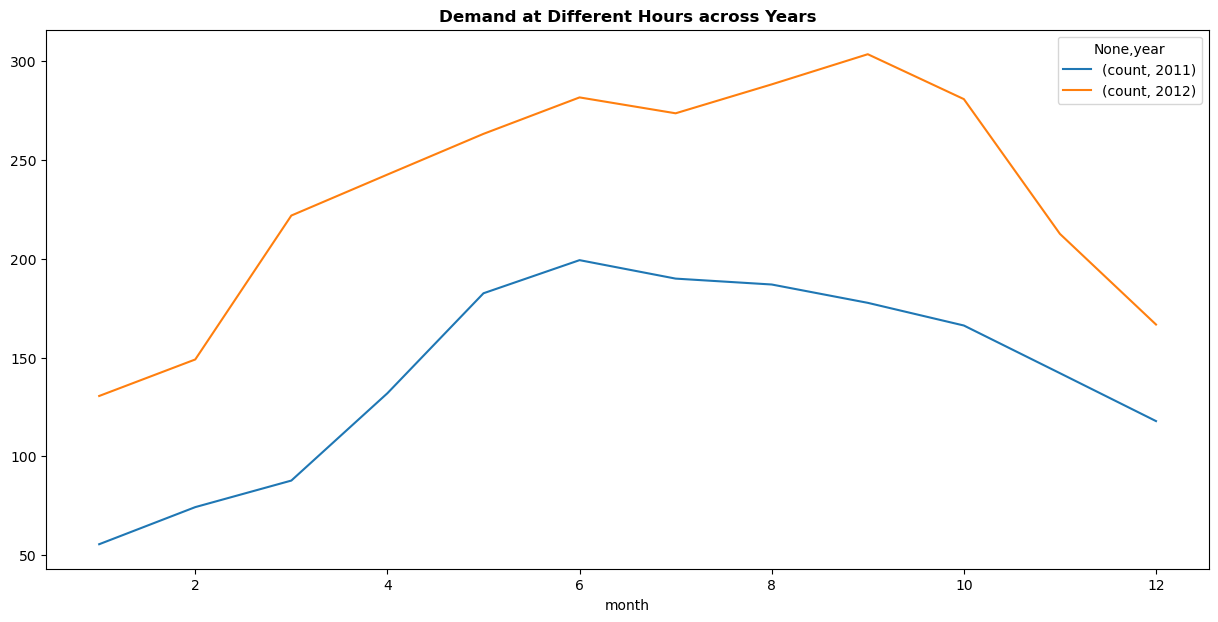

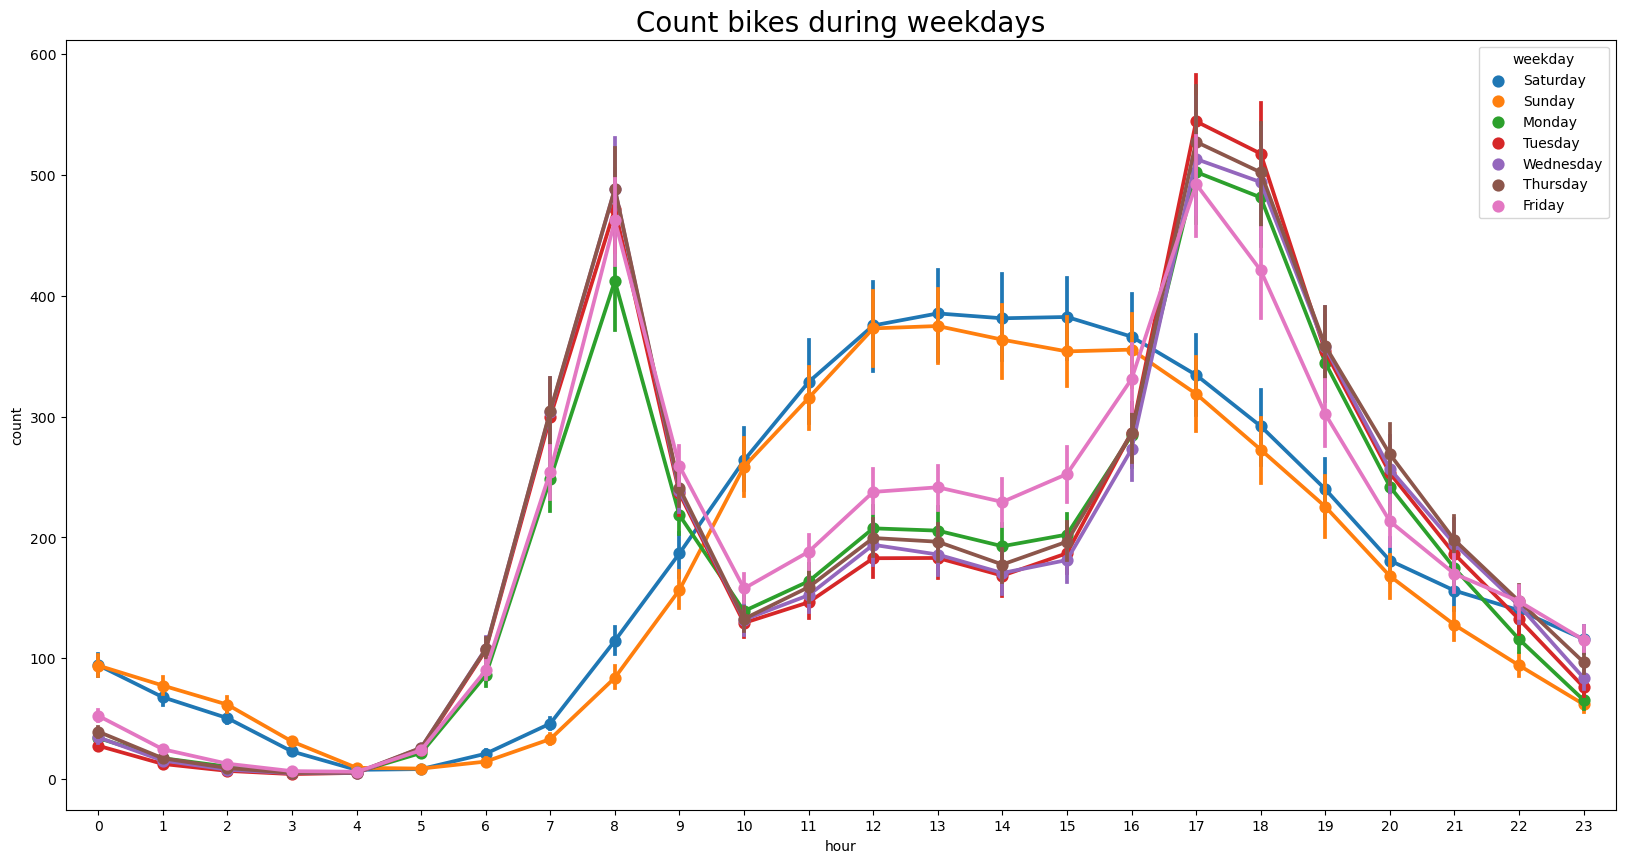

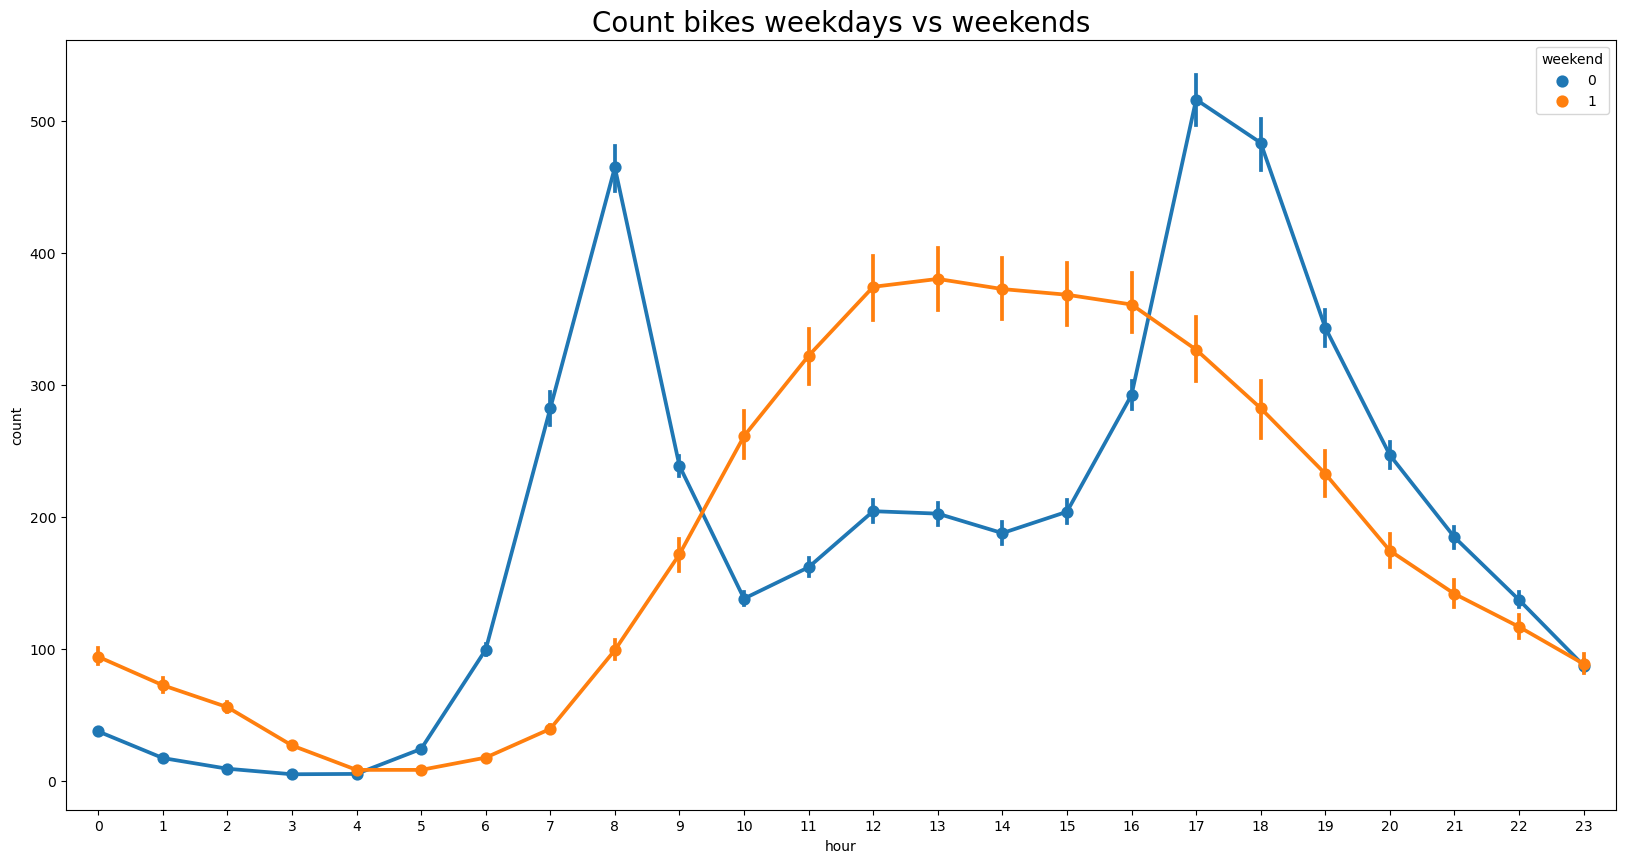

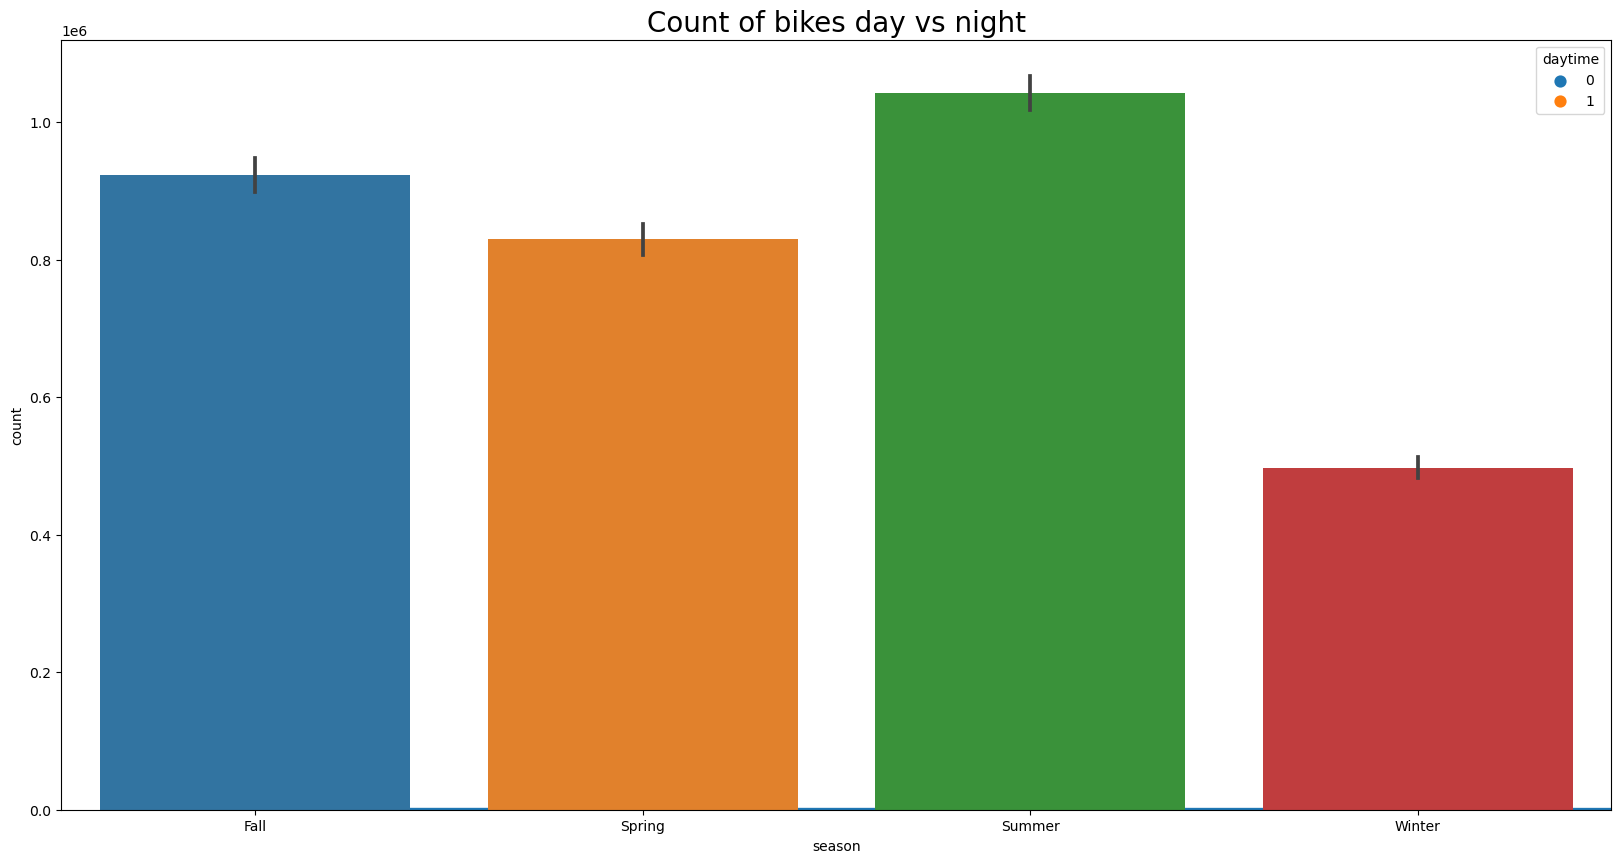

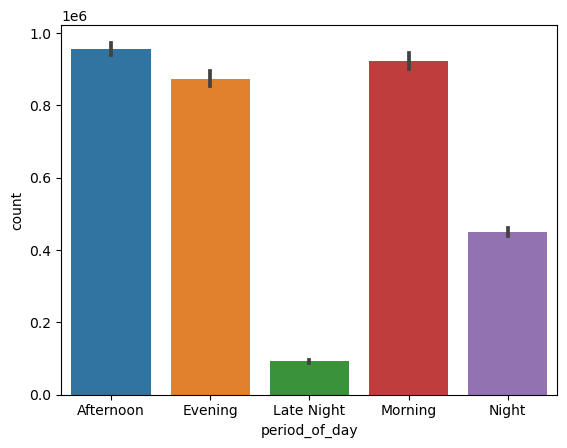

In [48]:
var = ['season', 'period_of_day']

for i in var:
    sns.barplot(x=i,y='count',data=df,estimator=sum)
    plt.show()

### Correlation matrix checking the new features

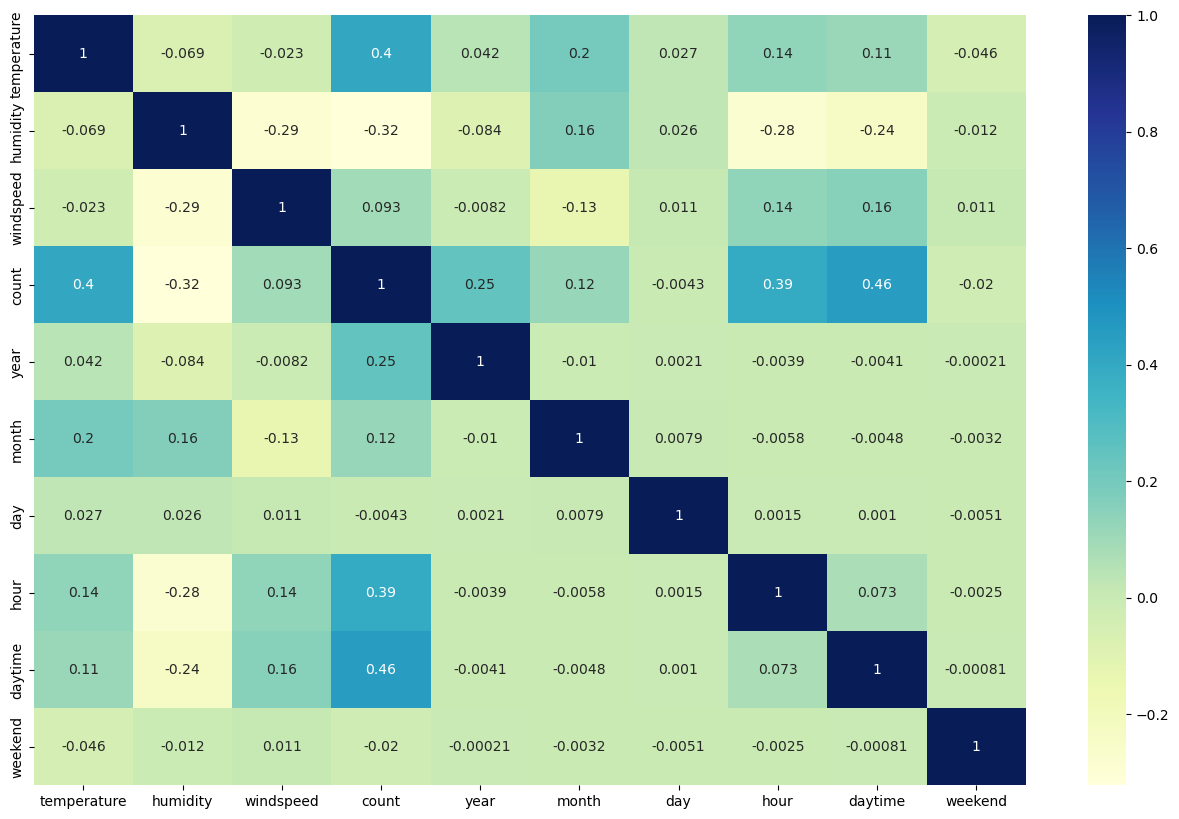

In [49]:
plt.figure(figsize = (16, 10))
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [50]:
df.head()

,date,temperature,humidity,windspeed,count,hour_group,year,month,day,hour,daytime,weekday,weekend,weather_conditions,season,is_holiday,period_of_day
0,2011-01-01 00:00:00,0.24,0.81,0.0,16,"[0, 4)",2011,1,1,0,0,Saturday,1,0,Winter,0,Late Night
1,2011-01-01 01:00:00,0.22,0.80,0.0,40,"[0, 4)",2011,1,1,1,0,Saturday,1,0,Winter,0,Late Night
2,2011-01-01 02:00:00,0.22,0.80,0.0,32,"[0, 4)",2011,1,1,2,0,Saturday,1,0,Winter,0,Late Night
3,2011-01-01 03:00:00,0.24,0.75,0.0,13,"[0, 4)",2011,1,1,3,0,Saturday,1,0,Winter,0,Late Night
4,2011-01-01 04:00:00,0.24,0.75,0.0,1,"[4, 8)",2011,1,1,4,0,Saturday,1,0,Winter,0,Late Night


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                17379 non-null  datetime64[ns]
 1   temperature         17379 non-null  float64       
 2   humidity            17379 non-null  float64       
 3   windspeed           17379 non-null  float64       
 4   count               17379 non-null  int64         
 5   hour_group          17379 non-null  category      
 6   year                17379 non-null  int64         
 7   month               17379 non-null  int64         
 8   day                 17379 non-null  int64         
 9   hour                17379 non-null  int64         
 10  daytime             17379 non-null  int64         
 11  weekday             17379 non-null  object        
 12  weekend             17379 non-null  int64         
 13  weather_conditions  17379 non-null  category  

### Part 3: Machine Learning
1. Choosing sensible models (linear and non-linear)
    * Baseline Linear Regression with Initial Variables
    * Linear Regression with New Variables
    * Baseline Random Forest
2. Tuning model parameters with validation
3. Obtaining accurate predictions in test
4. Plotting predictions vs reality for additional insights

### Creating a linear regression model with new variables

In [52]:
x = df.drop(columns={'date','count'})
y = df['count']

In [53]:
categorical_features = list(x.select_dtypes(include=["object", "category"]).columns)
numerical_features = list(x.select_dtypes(include=["float64", "int64"]).columns)

In [54]:
# Define categorical pipeline
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])


# Fit column transformer to training data
preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("num", num_pipe, numerical_features)
])

preprocessor.fit(x)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['hour_group', 'weekday', 'weather_conditions',
                                  'season', 'is_holiday', 'period_of_day']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['temperature', 'humidity', 'windspeed',
                                  'year', 'month', 'day', 'hour', 'daytime',
 

In [55]:
preprocessor.fit_transform(x)

array([[ 1.        ,  0.        ,  0.        , ..., -1.        ,
        -1.        ,  1.        ],
       [ 1.        ,  0.        ,  0.        , ..., -0.91666667,
        -1.        ,  1.        ],
       [ 1.        ,  0.        ,  0.        , ..., -0.83333333,
        -1.        ,  1.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.75      ,
        -1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.83333333,
        -1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.91666667,
        -1.        ,  0.        ]])

In [56]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.125, random_state=101, shuffle=False)

In [57]:
linear_regression = Pipeline([
    ("preprocessor", preprocessor),
    ("LinearRegression", LinearRegression())    
])

In [58]:
linear_regression.fit(x_train, y_train)
pred = linear_regression.predict(x_test)
r2_score(y_test, pred)

0.5634715053355412

### Creating pipelines to check the model scores

In [59]:
Random_forest = Pipeline([
    ("preprocessor", preprocessor),
    ("Randomforestregressor", RandomForestRegressor(random_state=42))
])

Decision_Tree = Pipeline([
    ("preprocessor", preprocessor),
    ("DecisionTree", DecisionTreeRegressor(random_state=42))   
])

Ridge_regression = Pipeline([
    ("preprocessor", preprocessor),
    ("Ridge", Ridge())
])

Lasso_regression = Pipeline([
    ("preprocessor", preprocessor),
    ("Lasso", Lasso())
])

SVM = Pipeline([
    ("preprocessor", preprocessor),
    ("svm", SVR(kernel = "linear"))
])

In [60]:
algorithms = [Random_forest, Decision_Tree, Ridge_regression, Lasso_regression, SVM]
algo = ['Random_Forest', 'Decision_Tree', 'Ridge_Regression', 'Lasso_Regression', 'SVM']



for algo,i in zip(algorithms,algo):
    algo.fit(x_train, y_train)
    pred = algo.predict(x_test)
    print(f"The R2 score for {i} is: {r2_score(y_test, pred)}") 

The R2 score for Random_Forest is: 0.8394577114340619
The R2 score for Decision_Tree is: 0.711177523377305
The R2 score for Ridge_Regression is: 0.5627606038306763
The R2 score for Lasso_Regression is: 0.540097303244602
The R2 score for SVM is: 0.4959719205933558


### Hyperparameter tuning

In [62]:
param_grid = [
    {
        'Randomforestregressor__max_depth': [5, None],
        'Randomforestregressor__n_estimators': [300],
        "Randomforestregressor__max_samples": [0.99],
        'Randomforestregressor__max_features': [0.6, 0.8],
        'Randomforestregressor__min_samples_leaf': [1],
        'Randomforestregressor__min_samples_split': [5]
    }]

grid = GridSearchCV(
    Random_forest,
    param_grid,
    scoring="r2", 
    cv=3,
    n_jobs= 1,
    verbose= 2
)

grid.fit(x_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END Randomforestregressor__max_depth=5, Randomforestregressor__max_features=0.6, Randomforestregressor__max_samples=0.99, Randomforestregressor__min_samples_leaf=1, Randomforestregressor__min_samples_split=5, Randomforestregressor__n_estimators=300; total time=   2.7s
[CV] END Randomforestregressor__max_depth=5, Randomforestregressor__max_features=0.6, Randomforestregressor__max_samples=0.99, Randomforestregressor__min_samples_leaf=1, Randomforestregressor__min_samples_split=5, Randomforestregressor__n_estimators=300; total time=   2.7s
[CV] END Randomforestregressor__max_depth=5, Randomforestregressor__max_features=0.6, Randomforestregressor__max_samples=0.99, Randomforestregressor__min_samples_leaf=1, Randomforestregressor__min_samples_split=5, Randomforestregressor__n_estimators=300; total time=   2.6s
[CV] END Randomforestregressor__max_depth=5, Randomforestregressor__max_features=0.8, Randomforestregressor__max_sampl

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['hour_group',
                                                                          'weekday',
                                                                          'weather_cond

In [63]:
grid.best_score_

0.7272108145148263

In [64]:
grid.best_params_

{'Randomforestregressor__max_depth': None,
 'Randomforestregressor__max_features': 0.6,
 'Randomforestregressor__max_samples': 0.99,
 'Randomforestregressor__min_samples_leaf': 1,
 'Randomforestregressor__min_samples_split': 5,
 'Randomforestregressor__n_estimators': 300}

In [65]:
grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['hour_group', 'weekday',
                                                   'weather_conditions',
                                                   'season', 'is_holiday',
                                                   'period_of_day']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
           

In [66]:
random_forest_regressor = Pipeline([
    ("preprocessor", preprocessor),
    ("Randomforestregressor", RandomForestRegressor(random_state=0, max_depth= 20, max_features= 0.6, 
                                                    max_samples=0.6, min_samples_leaf=2, min_samples_split=5,
                                                    n_estimators=200))
                                                    
])

In [67]:
random_forest_regressor.fit(x_train, y_train)
pred = random_forest_regressor.predict(x_test)
r2_score(y_test, pred)

0.8509335468899057

### Plotting the validation curve

In [68]:
train_scores, test_scores = validation_curve(
    random_forest_regressor,
    x_train,
    y_train,
    param_name="Randomforestregressor__max_depth",
    param_range=range(1, 20),
    cv=3
)

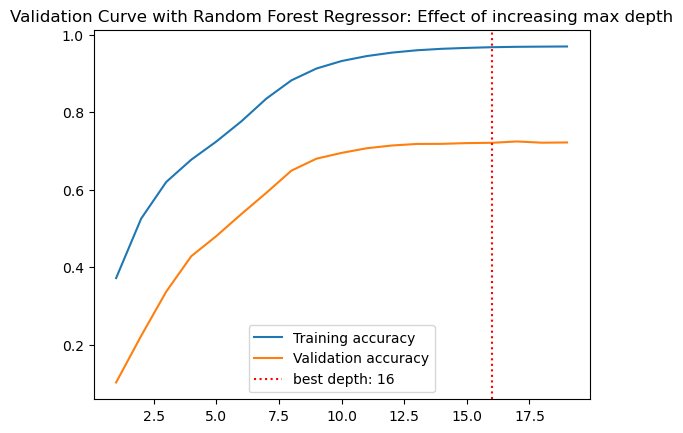

In [69]:
max_test_scores = np.argmax(test_scores.mean(axis=1)) 

plt.plot(range(1, 20), train_scores.mean(axis=1), label="Training accuracy")  
plt.plot(range(1, 20), test_scores.mean(axis=1), label="Validation accuracy")
plt.axvline(max_test_scores, c="red", linestyle=":", label=f"best depth: {max_test_scores}")
plt.title("Validation Curve with Random Forest Regressor: Effect of increasing max depth")
plt.legend()
plt.show()

## Finding the feature importance 

In [70]:
random_forest_regressor.steps[1][1].feature_importances_

array([1.87082576e-03, 6.61979023e-03, 5.82440605e-03, 5.40267485e-03,
       9.38732349e-02, 6.09322508e-03, 4.03386885e-03, 2.32652213e-03,
       7.43595473e-03, 9.61166058e-03, 9.83690373e-04, 1.06326517e-03,
       1.15102923e-03, 3.15185410e-03, 1.36308338e-03, 1.15493854e-02,
       0.00000000e+00, 2.15845664e-03, 2.10263753e-03, 1.85787193e-03,
       9.90594254e-03, 2.70973951e-05, 2.71751975e-05, 9.00800693e-03,
       5.66521306e-02, 1.31957619e-02, 2.31044158e-03, 6.74718166e-03,
       1.43157536e-01, 2.93459818e-02, 8.15515277e-03, 8.45082936e-02,
       2.53341159e-02, 1.35854497e-02, 3.50155070e-01, 2.39573174e-02,
       5.54539079e-02])

In [71]:
feat_dict= {}
for col, val in sorted(zip(x_train.columns, random_forest_regressor.steps[1][1].feature_importances_),key=lambda x:x[1],reverse=True):
    feat_dict[col]=val

In [72]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
feat_df

,Feature,Importance
0,year,0.093873
1,weekday,0.009612
2,daytime,0.007436
3,humidity,0.006620
4,month,0.006093
5,windspeed,0.005824
6,hour_group,0.005403
7,day,0.004034
8,is_holiday,0.003152
9,hour,0.002327


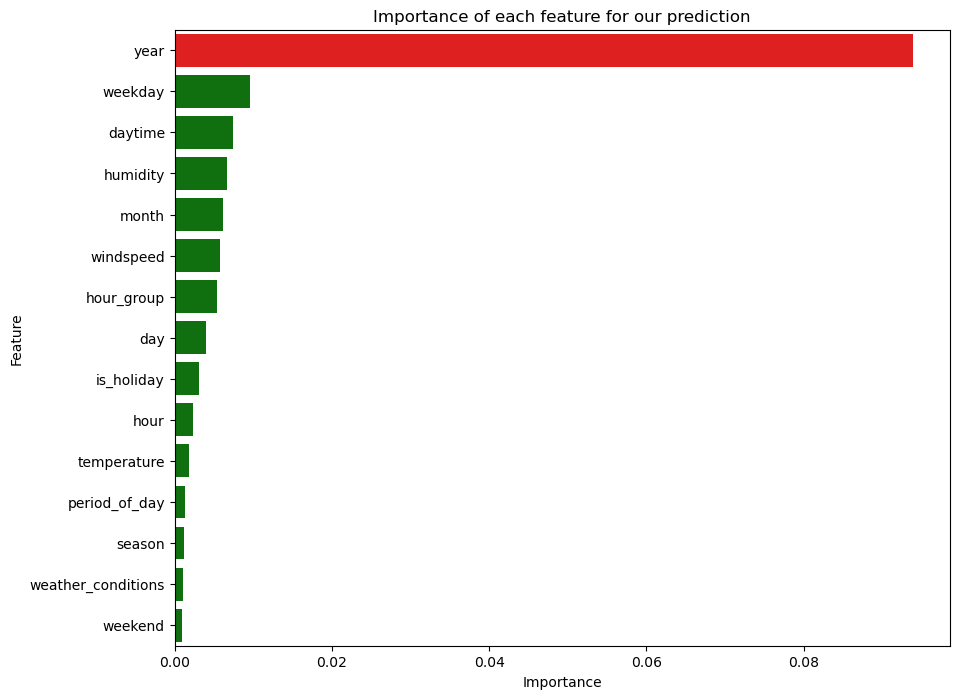

In [73]:
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Importance of each feature for our prediction')
plt.show()

<AxesSubplot:>

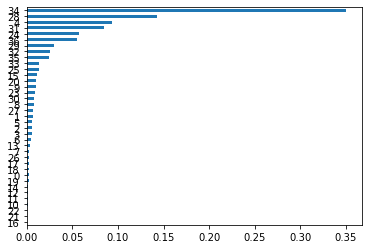

In [83]:
feat_importances = pd.Series(random_forest_regressor.steps[1][1].feature_importances_)
feat_importances.sort_values(ascending=True,inplace=True)
feat_importances.plot(kind='barh')

## Plotting  Predictions vs Real Values

Text(0.5, 1.0, 'Scatter plot showing Predictions vs Real Values')

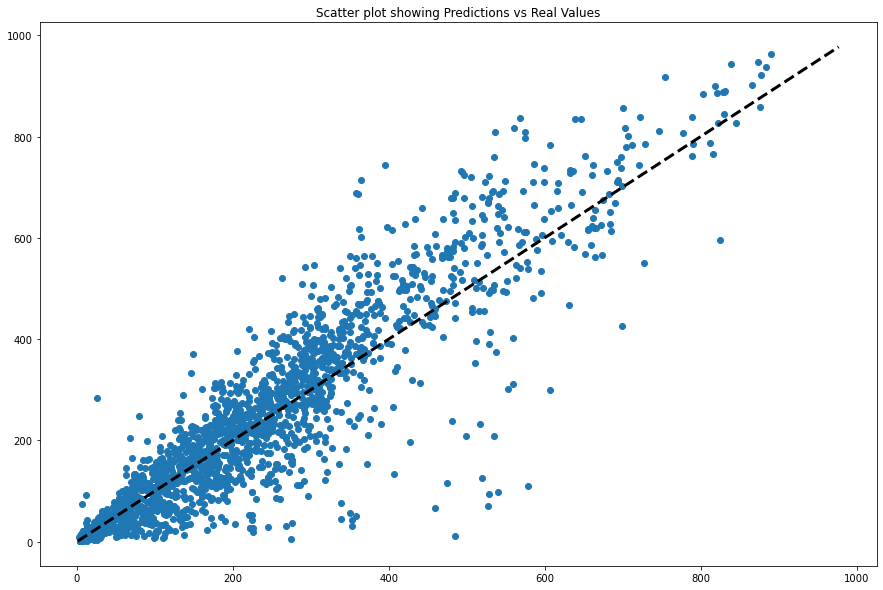

In [82]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(pred, y_test)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)


ax.set_title("Scatter plot showing Predictions vs Real Values")

In [22]:
%matplotlib inline